<a href="https://colab.research.google.com/github/MorkMongkul/Deep-Learning-Project/blob/main/kh_Bert_Sentiment_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## For Word Segmentation

In [2]:
! git clone https://github.com/rinabuoy/KhmerNLP

Cloning into 'KhmerNLP'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 265 (delta 36), reused 40 (delta 16), pack-reused 189 (from 1)
Receiving objects: 100% (265/265), 38.10 MiB | 13.12 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Updating files: 100% (28/28), done.
Encountered 2 file(s) that should have been pointers, but weren't:
	assets/sklearn_crf_model_90k-100i.sav
	assets/word_segmentation_model.pt


In [3]:
%cd KhmerNLP

/content/KhmerNLP


In [4]:
!pip install sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.1 MB/s eta 0:00:00


In [49]:
import os
from transformers import TFAutoModel,AutoTokenizer,BertModel,AdamW,XLMRobertaTokenizer,XLMRobertaForSequenceClassification, Trainer, TrainingArguments,XLMRobertaModel
from datasets import Dataset,load_dataset
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import classification_report, confusion_matrix
from khmerwordsegmentor import KhmerWordSegmentor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Load Data and Preprocessing

In [7]:
data = pd.read_csv('/content/kh_sentiment_data.csv')

In [8]:
data.head(10)

,ID,Text,Sentiment_text,Sentiment_label
0,1,ខ្ញុំចូលចិត្តវា,Positive,1.0
1,2,ផលិតផលនេះគុណភាពល្អ,Positive,1.0
2,3,ប្រើប្រាស់មិនបានយូ ហើយថ្លៃទៀត,Negative,0.0
3,4,នៅតែពេញនិយមស្តាប់មិនធុញ,Positive,1.0
4,5,ខ្ញុំអត់ចូលចិត្តត្រង់ កាមេរ៉ា មហាអន់ និយាយមែន,Negative,0.0
5,6,ខ្ញុំអត់ពេញចិត្តរូប១សន្លឹកដែលថតនោះ,Negative,0.0
6,7,ផលិតបានល្អខ្លាំងណាស់,Positive,1.0
7,8,ខ្ញុំស្ដាប់10ដងហើយនៅតែពិរស់,Positive,1.0
8,9,អ្នកបើកបរមានសុជីវធម៍ល្អ លើកក្រោយចង់ជិះជាមួយគាត...,Positive,1.0
9,10,សូមខំមិនរឿងអ្នកបើកបរម្សិលមិញពីសៀមរាបមកភ្នំពេញម...,Negative,0.0


In [9]:
data.isna().sum() #missing value

,0
ID,0
Text,0
Sentiment_text,0
Sentiment_label,0


In [10]:
data['Sentiment_label'].value_counts() # Check class label, prevent from imbalance class

,count
Sentiment_label,
1.0,599
0.0,515


# Word Segmentation

In [11]:
# Initialize the segmentor
seg = KhmerWordSegmentor()
def segment_khmer_text(text, model="lstm"):
    """
    Segment Khmer text using the specified model (LSTM or CRF).

    Parameters:
        text (str): The input Khmer text to be segmented.
        model (str): The model to use for segmentation ('lstm' or 'crf').

    Returns:
        str: The segmented text as a string.
    """
    try:
        # Segment the text
        segmented_text = seg.segment(text, model=model)
        return segmented_text
    except Exception as e:
        print(f"Error during segmentation: {e}")
        return ""

Inference on GPU!


/content/KhmerNLP/khmerwordsegmentor.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.bilstmModel = torch.load(bilstm_model_path)


In [12]:
data['seg_text_lstm'] = data['Text'].apply(lambda x: segment_khmer_text(x, model='lstm')) # apply word segmentation using "LSTM"
data['seg_text_crf'] = data['Text'].apply(lambda x: segment_khmer_text(x,model = 'crf')) # apply word segmentation using "CRF"

In [13]:
data.head(10)

,ID,Text,Sentiment_text,Sentiment_label,seg_text_lstm,seg_text_crf
0,1,ខ្ញុំចូលចិត្តវា,Positive,1.0,ខ្ញុំ ចូលចិត្ត វា,ខ្ញុំ ចូលចិត្ត វា
1,2,ផលិតផលនេះគុណភាពល្អ,Positive,1.0,ផលិតផល នេះ គុណភាព ល្អ,ផលិតផល នេះ គុណភាព ល្អ
2,3,ប្រើប្រាស់មិនបានយូ ហើយថ្លៃទៀត,Negative,0.0,ប្រើប្រាស់ មិន បាន យូហើយ ថ្លៃ ទៀត,ប្រើប្រាស់ មិន បាន យូហើយ ថ្លៃ ទៀត
3,4,នៅតែពេញនិយមស្តាប់មិនធុញ,Positive,1.0,នៅតែ ពេញនិយម ស្តាប់ មិន ធុញ,នៅតែ ពេញនិយម ស្តាប់ មិន ធុញ
4,5,ខ្ញុំអត់ចូលចិត្តត្រង់ កាមេរ៉ា មហាអន់ និយាយមែន,Negative,0.0,ខ្ញុំ អត់ ចូលចិត្ត ត្រង់ កាមេរ៉ា មហា អន់ និយាយ...,ខ្ញុំ អត់ ចូលចិត្ត ត្រង់ កាមេរ៉ា មហា អន់ និយាយ...
5,6,ខ្ញុំអត់ពេញចិត្តរូប១សន្លឹកដែលថតនោះ,Negative,0.0,ខ្ញុំ អត់ ពេញចិត្ត រូប ១ សន្លឹក ដែល ថត នោះ,ខ្ញុំ អត់ ពេញចិត្ត រូប ១ សន្លឹក ដែល ថត នោះ
6,7,ផលិតបានល្អខ្លាំងណាស់,Positive,1.0,ផលិត បាន ល្អ ខ្លាំង ណាស់,ផលិត បាន ល្អ ខ្លាំង ណាស់
7,8,ខ្ញុំស្ដាប់10ដងហើយនៅតែពិរស់,Positive,1.0,ខ្ញុំ ស្ដាប់ 10 ដង ហើយ នៅតែ ពិរស់,ខ្ញុំ ស្ដាប់ 10 ដង ហើយ នៅតែ ពិរស់
8,9,អ្នកបើកបរមានសុជីវធម៍ល្អ លើកក្រោយចង់ជិះជាមួយគាត...,Positive,1.0,អ្នកបើកបរ មាន សុជីវធម៍ ល្អ លើក ក្រោយ ចង់ ជិះ ជ...,អ្នកបើកបរ មាន សុជីវធម៍ ល្អ លើក ក្រោយ ចង់ ជិះ ជ...
9,10,សូមខំមិនរឿងអ្នកបើកបរម្សិលមិញពីសៀមរាបមកភ្នំពេញម...,Negative,0.0,សូម ខំ មិន រឿង អ្នកបើកបរ ម្សិលមិញ ពី សៀមរាប មក...,សូម ខំ មិន រឿង អ្នកបើកបរ ម្សិលមិញ ពី សៀមរាប មក...


In [14]:
data.to_csv('kh_sentiment_data_segmented.csv', index=False)

In [15]:
# Assume your DataFrame is named 'df' and contains 'seg_text' and 'Sentiment_label'
data = data[['seg_text_lstm', 'Sentiment_label']]  # Use segmented text column and sentiment label

# Split into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2)

# Tokenization

In [16]:
# Load the XLM-Roberta tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

# Create a customer dataset using Pytorch

In [25]:

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.texts = dataframe['seg_text_lstm'].tolist()  # Assuming segmented text is here
        self.labels = dataframe['Sentiment_label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Return tensors
        return {
            'input_ids': encoded['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }



In [27]:
# Define parameters
max_length = 128  # Maximum token length
batch_size = 16   # Batch size

# Create datasets
train_dataset = CustomDataset(train_data, tokenizer, max_length)
val_dataset = CustomDataset(val_data, tokenizer, max_length)

In [29]:
# Retrieve the first sample
sample = train_dataset[0]
# Print the tokenized data
print("Input IDs:", sample['input_ids'])
print("Attention Mask:", sample['attention_mask'])
print("Label:", sample['label'])

Input IDs: tensor([    0, 77455, 41023,  7937,  5603, 30029, 75591,  5311,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,    

In [30]:
# Create dataloaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define Pre-train Model

In [41]:
class XLMRClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super(XLMRClassifier, self).__init__()
        self.xlm_roberta = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)

        # For binary classification, output 2 logits (for class 0 and 1)
        self.fc = nn.Linear(self.xlm_roberta.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the [CLS] token representation
        pooled_output = outputs[0][:, 0, :]

        # Apply dropout and fully connected layer
        x = self.dropout(pooled_output)
        logits = self.fc(x)

        return logits


# Training

In [60]:

# Initialize the model
model = XLMRobertaClassifier(model_name='xlm-roberta-base', num_classes=2)  # Example: binary classification
model.to(device)

# Define the optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()  # For classification tasks


In [61]:
# Training loop
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # tqdm for showing the progress bar
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        optimizer.zero_grad()

        # Get input and output from the batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get logits (the first element of the tuple)
        logits = outputs

        # Compute loss
        loss = criterion(logits, labels)

        # Backpropagation
        loss.backward()

        # Update parameters
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for this epoch
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10: 100%|██████████| 56/56 [00:22<00:00,  2.52it/s]


Epoch 1/10, Loss: 0.7001


Epoch 2/10: 100%|██████████| 56/56 [00:22<00:00,  2.50it/s]


Epoch 2/10, Loss: 0.6728


Epoch 3/10: 100%|██████████| 56/56 [00:22<00:00,  2.53it/s]


Epoch 3/10, Loss: 0.5675


Epoch 4/10: 100%|██████████| 56/56 [00:21<00:00,  2.55it/s]


Epoch 4/10, Loss: 0.5052


Epoch 5/10: 100%|██████████| 56/56 [00:22<00:00,  2.54it/s]


Epoch 5/10, Loss: 0.4709


Epoch 6/10: 100%|██████████| 56/56 [00:22<00:00,  2.53it/s]


Epoch 6/10, Loss: 0.4970


Epoch 7/10: 100%|██████████| 56/56 [00:22<00:00,  2.53it/s]


Epoch 7/10, Loss: 0.3917


Epoch 8/10: 100%|██████████| 56/56 [00:22<00:00,  2.53it/s]


Epoch 8/10, Loss: 0.3480


Epoch 9/10: 100%|██████████| 56/56 [00:22<00:00,  2.54it/s]


Epoch 9/10, Loss: 0.3853


Epoch 10/10: 100%|██████████| 56/56 [00:22<00:00,  2.53it/s]

Epoch 10/10, Loss: 0.3509


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       101
           1       0.77      0.93      0.84       122

    accuracy                           0.81       223
   macro avg       0.83      0.80      0.80       223
weighted avg       0.83      0.81      0.81       223

Confusion Matrix:
[[ 67  34]
 [  8 114]]


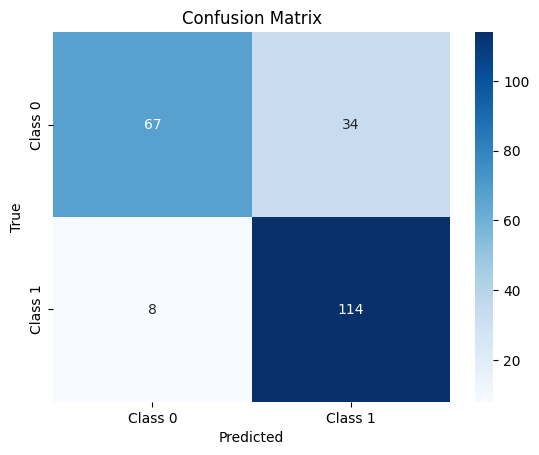

In [88]:
# Set model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in val_data_loader:
        # Send inputs and labels to the device (GPU/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract logits and compute predictions
        logits = outputs
        _, preds = torch.max(logits, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Visualization of the confusion matrix (optional)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [71]:
# Save the trained model
torch.save(model, 'xlmr_classifier_complete.pth')  # Saves the entire model, including architecture and weights

# Save the tokenizer
tokenizer.save_pretrained('xlmr_tokenizer')

# Save the word segmentation model
with open('word_segmentor.pickle', 'wb') as f:
    pickle.dump(seg, f)

print("Model, tokenizer, and word segmentor saved successfully!")

Model, tokenizer, and word segmentor saved successfully!


In [84]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
seg = KhmerWordSegmentor()
# Save the model, tokenizer, and word segmentor as a single .pkl file
def save_model_and_tokenizer(model, tokenizer, segmentor, filename='saved_model.pkl'):
    model_data = {
        'model': model,
        'tokenizer': tokenizer,
        'segmentor': segmentor
    }
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)

# Call the function to save
save_model_and_tokenizer(model, tokenizer, seg)
print("Model, tokenizer, and segmentor saved successfully.")

Inference on GPU!


/content/KhmerNLP/khmerwordsegmentor.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.bilstmModel = torch.load(bilstm_model_path)


Model, tokenizer, and segmentor saved successfully.


In [72]:
# Load the entire model (including architecture and weights)
model = torch.load('xlmr_classifier_complete.pth')
model.eval()  # Set the model to evaluation mode

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlmr_tokenizer')

# Load the word segmentation model
with open('word_segmentor.pickle', 'rb') as f:
    seg = pickle.load(f)

print("Model, tokenizer, and word segmentor loaded successfully!")

<ipython-input-72-13e6ad5341d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('xlmr_classifier_complete.pth')


Model, tokenizer, and word segmentor loaded successfully!


In [83]:
# Ensure that the model is in evaluation mode and moved to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Input text for prediction
input_text ="ងាយ​ស្រួល​កក់​សំបុត្រ​ ជិះ​លឿន​ឈប់​តែ​ម្ដង​ឆាប់​ដល់​ទី​តាំង​"

# Perform word segmentation (if required)
segmented_text = seg.segment(input_text, model='lstm')

# Tokenize the input text
inputs = tokenizer(segmented_text, return_tensors='pt', padding=True, truncation=True)

# Move the input tensors to the same device as the model
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

# Forward pass through the model
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

# Get predictions
predictions = outputs.argmax(dim=-1)
print("Predicted class:", predictions.item())


Predicted class: 1


In [90]:
# Function to load saved model, tokenizer, and word segmentor
def load_model_and_tokenizer(filename='/content/saved_model.pkl'):
    with open(filename, 'rb') as f:
        model_data = pickle.load(f)
    model = model_data['model']
    tokenizer = model_data['tokenizer']
    segmentor = model_data['segmentor']
    return model, tokenizer, segmentor

# Load the saved model, tokenizer, and word segmentor
model, tokenizer, segmentor = load_model_and_tokenizer()

# Prepare text for prediction
text = "ពង្រឹង​វិន័យ​លេី​អ្នក​បេីកបរ​បន្ថែម​"
segmented_text = segmentor.segment(text, model='lstm')
print(f"Segmented text: {segmented_text}")

# Tokenize input text
inputs = tokenizer(segmented_text, return_tensors="pt", padding=True, truncation=True)

# Send model to device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs
    predicted_class = torch.argmax(logits, dim=1).item()

print(f"Predicted class: {predicted_class}")


Segmented text: ពង្រឹង វិន័យ លេី អ្នក បេីក បរ បន្ថែម
Predicted class: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
